# 2D Model Open Colony

This notebook implements a 2D extension of the 1D reaction-diffusion model, simmulating colony dynamcis, with open boundaries

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from numba import njit
import pickle
import seaborn as sns


# =============================== Units ===============================
# Lengths: micrometers (μm); Time: hours (h)
# Diffusion D: μm^2/h
# Production S: conc/h  (source in producer regions)
# Uptake C: 1/h         (proportional sink in consumer regions)

# --------------------------- Survival model --------------------------
@njit(cache=True, fastmath=True, nogil=True)
def inv_logit(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))


@njit(cache=True, fastmath=True, nogil=True)
def predict_survival(RHL: np.ndarray, HQNO: np.ndarray, m_rhl: float, m_hqno: float, b: float) -> np.ndarray:
    """Survival = σ(m_rhl * RHL + m_hqno * HQNO + b)."""
    return inv_logit(m_rhl * RHL + m_hqno * HQNO + b)


# --------------------------- Simulation config -----------------------
@dataclass
class SimConfig:
    # ----- geometry (μm) -----
    mode: str = "channel"            # "channel" or "chessboard"
    L_um: float = 50.0               # channel: length of producer & consumer each
    L_ext_um: float = 3.0           # channel: corridor length
    W_um: float = 50.0               # channel width; chessboard: target box size
    tile_um: float = 10.0            # chessboard: requested tile size (snapped to grid)

    # ----- grid (μm) -----
    dx_um: float = 1.0
    dy_um: float = 1.0

    # ----- physics (HQNO) -----
    D_HQNO_um2_per_s: float = 0.1
    S_HQNO_prod_per_s: float = 0.5
    up_HQNO_cons_per_s: float = 0.02

    # ----- physics (RHL) -----
    D_RHL_um2_per_s: float = 0.05
    S_RHL_prod_per_s: float = 0.2
    up_RHL_cons_per_s: float = 0.01

    # ----- time -----
    t_max_s: float = 1e4
    tol: float = 1e-6
    cfl_safety: float = 0.9
    max_steps: int = int(1e7)

    # ----- channel-only: reflecting strips in diffusion corridor -----
    use_reflecting_strips: bool = True
    strip_width_um: float = 3
    stripes_per_seight: int = 10

    # ----- survival parameters (loaded from JSON) -----
    m_rhl: float = 0.05
    m_hqno: float = -0.03
    b: float = 0.0
    compute_survival: bool = True

    # ----- numerics/IO -----
    use_float32: bool = True
    verbose: bool = True
    make_plots: bool = True

# ----------------------------- Utilities -----------------------------
def _cfl_dt(dx, dy, Dmax, safety=0.9):
    # Explicit 2-D 5-point stencil:
    # dt <= dx^2 * dy^2 / [ 2 * D * (dx^2 + dy^2) ]
    return safety * (dx*dx * dy*dy) / (2.0 * Dmax * (dx*dx + dy*dy))

@njit(cache=True, fastmath=True, nogil=True)
def _laplacian_periodic(A: np.ndarray, dx: float, dy: float) -> np.ndarray:
    nx: int = A.shape[0]
    ny: int = A.shape[1]
    out = np.empty_like(A)
    inv_dx2: float = 1.0 / (dx * dx)
    inv_dy2: float = 1.0 / (dy * dy)
    for i in range(nx):
        ip = i + 1 if i + 1 < nx else 0
        im = i - 1 if i - 1 >= 0 else nx - 1
        for j in range(ny):
            jp = j + 1 if j + 1 < ny else 0
            jm = j - 1 if j - 1 >= 0 else ny - 1
            center = A[i, j]
            out[i, j] = (A[ip, j] + A[im, j] - 2.0 * center) * inv_dx2 + (A[i, jp] + A[i, jm] - 2.0 * center) * inv_dy2
    return out

@njit(cache=True, fastmath=True, nogil=True)
def _laplacian_channel(R: np.ndarray, dx: float, dy: float, walls: np.ndarray) -> np.ndarray:
    nx: int = R.shape[0]
    ny: int = R.shape[1]
    out = np.zeros_like(R)
    inv_dx2: float = 1.0 / (dx * dx)
    inv_dy2: float = 1.0 / (dy * dy)
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            center = R[i, j]
            if np.isnan(center):
                out[i, j] = np.nan
                continue
            r_right = R[i + 1, j] if not (walls[i + 1, j] or np.isnan(R[i + 1, j])) else center
            r_left = R[i - 1, j] if not (walls[i - 1, j] or np.isnan(R[i - 1, j])) else center
            r_up = R[i, j + 1] if not (walls[i, j + 1] or np.isnan(R[i, j + 1])) else center
            r_down = R[i, j - 1] if not (walls[i, j - 1] or np.isnan(R[i, j - 1])) else center
            out[i, j] = (r_right + r_left - 2.0 * center) * inv_dx2 + (r_up + r_down - 2.0 * center) * inv_dy2
    return out

@njit(cache=True, fastmath=True, nogil=True)
def _time_step_loop(
    HQNO: np.ndarray,
    RHL: np.ndarray,
    S_HQNO: np.ndarray,
    k_HQNO: np.ndarray,
    S_RHL: np.ndarray,
    k_RHL: np.ndarray,
    walls: np.ndarray,
    dx: float,
    dy: float,
    dt: float,
    D1: float,
    D2: float,
    t_max: float,
    tol: float,
    max_steps: int,
    mode: int
) -> tuple:
    """
    Time-stepping loop with explicit typing.
    mode: 0=chessboard (periodic), 1=channel, 2=open_chessboard
    Returns: (HQNO, RHL, t, steps)
    """
    nx: int = HQNO.shape[0]
    ny: int = HQNO.shape[1]
    HQNO_new = np.empty_like(HQNO)
    RHL_new = np.empty_like(RHL)
    
    t: float = 0.0
    steps: int = 0
    has_walls: bool = np.any(walls)
    
    while t < t_max and steps < max_steps:
        if mode == 0:  # chessboard (periodic)
            lap_HQNO = _laplacian_periodic(HQNO, dx, dy)
            lap_RHL = _laplacian_periodic(RHL, dx, dy)
            HQNO_new[:, :] = HQNO + dt * (D1 * lap_HQNO + S_HQNO - k_HQNO * HQNO)
            RHL_new[:, :] = RHL + dt * (D2 * lap_RHL + S_RHL - k_RHL * RHL)
        else:
            # Interior Laplacians
            lap_HQNO = _laplacian_channel(HQNO, dx, dy, walls)
            lap_RHL = _laplacian_channel(RHL, dx, dy, walls)
            HQNO_new[:, :] = HQNO
            RHL_new[:, :] = RHL
            
            # Update interior
            for i in range(1, nx - 1):
                for j in range(1, ny - 1):
                    HQNO_new[i, j] = HQNO[i, j] + dt * (
                        D1 * lap_HQNO[i, j] + S_HQNO[i, j] - k_HQNO[i, j] * HQNO[i, j]
                    )
                    RHL_new[i, j] = RHL[i, j] + dt * (
                        D2 * lap_RHL[i, j] + S_RHL[i, j] - k_RHL[i, j] * RHL[i, j]
                    )
            
            if mode == 1:  # channel
                # Absorbing at x, reflecting at y
                for j in range(ny):
                    HQNO_new[0, j] = 0.0
                    HQNO_new[nx - 1, j] = 0.0
                    RHL_new[0, j] = 0.0
                    RHL_new[nx - 1, j] = 0.0
                for i in range(nx):
                    HQNO_new[i, 0] = HQNO_new[i, 1]
                    HQNO_new[i, ny - 1] = HQNO_new[i, ny - 2]
                    RHL_new[i, 0] = RHL_new[i, 1]
                    RHL_new[i, ny - 1] = RHL_new[i, ny - 2]
                if has_walls:
                    for i in range(nx):
                        for j in range(ny):
                            if walls[i, j]:
                                HQNO_new[i, j] = np.nan
                                RHL_new[i, j] = np.nan
            elif mode == 2:  # open_chessboard
                # Absorbing at all boundaries
                for j in range(ny):
                    HQNO_new[0, j] = 0.0
                    HQNO_new[nx - 1, j] = 0.0
                    RHL_new[0, j] = 0.0
                    RHL_new[nx - 1, j] = 0.0
                for i in range(nx):
                    HQNO_new[i, 0] = 0.0
                    HQNO_new[i, ny - 1] = 0.0
                    RHL_new[i, 0] = 0.0
                    RHL_new[i, ny - 1] = 0.0
        
        # Convergence check
        diff_h: float = 0.0
        diff_r: float = 0.0
        for i in range(nx):
            for j in range(ny):
                d_h = abs(HQNO_new[i, j] - HQNO[i, j])
                d_r = abs(RHL_new[i, j] - RHL[i, j])
                if not np.isnan(d_h) and d_h > diff_h:
                    diff_h = d_h
                if not np.isnan(d_r) and d_r > diff_r:
                    diff_r = d_r
        
        diff: float = max(diff_h, diff_r)
        
        # Swap arrays
        HQNO, HQNO_new = HQNO_new, HQNO
        RHL, RHL_new = RHL_new, RHL
        
        t += dt
        steps += 1
        
        if diff < tol:
            break
    
    return (HQNO, RHL, t, steps)

# --------------------------- Geometry builders ------------------------
def _channel_masks(nx, ny, cfg, dx, dy):
    """Build S/k fields, walls and masks for the channel layout."""
    S_HQNO = np.zeros((nx, ny), dtype=np.float32)
    k_HQNO = np.zeros((nx, ny), dtype=np.float32)
    S_RHL  = np.zeros((nx, ny), dtype=np.float32)
    k_RHL  = np.zeros((nx, ny), dtype=np.float32)

    prod_end = int(round(cfg.L_um / dx))
    diff_end = int(round((cfg.L_um + cfg.L_ext_um) / dx))
    cons_end = int(round((2*cfg.L_um + cfg.L_ext_um) / dx))

    S_HQNO[:prod_end, :] = cfg.S_HQNO_prod_per_s
    S_RHL[:prod_end, :] = cfg.S_RHL_prod_per_s
    k_HQNO[diff_end:cons_end, :] = cfg.up_HQNO_cons_per_s
    k_RHL[diff_end:cons_end, :] = cfg.up_RHL_cons_per_s

    walls = np.zeros((nx, ny), dtype=bool)
    if cfg.use_reflecting_strips and cfg.strip_width_um > 0 and cfg.stripes_per_seight > 0:
        strip_w_cells = max(1, int(round(cfg.strip_width_um / dy)))
        period_cells  = max(2, ny // cfg.stripes_per_seight)
        offset = period_cells // 2
        x0, x1 = prod_end, diff_end
        for y0 in range(offset, ny, period_cells):
            y1 = min(y0 + strip_w_cells, ny)
            walls[x0:x1, y0:y1] = True

    consumer_mask = np.zeros((nx, ny), dtype=bool)
    consumer_mask[diff_end:cons_end, :] = True
    return S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask, prod_end, diff_end, cons_end

def _create_chessboard(nx, ny, ds):
    """Create centered chessboard pattern with square size ds."""
    x = np.arange(nx) - nx // 2
    y = np.arange(ny) - ny // 2
    xx, yy = np.meshgrid(x, y, indexing='ij')
    return ((xx // ds) + (yy // ds)) % 2


def _chessboard_domain(cfg, dx, dy):
    """Choose domain so Lx,Ly are integer multiples of tile; even tile count; corners=centered."""
    tx = max(1, int(round(cfg.tile_um / dx)))
    ty = max(1, int(round(cfg.tile_um / dy)))
    tile_x_um = tx * dx; tile_y_um = ty * dy
    nx_tiles = max(1, int(round(cfg.W_um / tile_x_um)))
    ny_tiles = max(1, int(round(cfg.W_um / tile_y_um)))
    if (nx_tiles * ny_tiles) % 2 == 1:
        nx_tiles += 1
    Lx = nx_tiles * tile_x_um
    Ly = ny_tiles * tile_y_um
    nx = int(round(Lx / dx))      # periodic: no +1
    ny = int(round(Ly / dy))
    return Lx, Ly, nx, ny, tx, ty

def _open_chessboard_masks(cfg, dx, dy, nx, ny):
    """Alternating producer/consumer with half-tile shift; no internal walls."""
    tx = max(1, int(round(cfg.tile_um / dx)))
    pattern = _create_chessboard(nx-2, ny-2, tx)

    producer_mask = np.zeros((nx, ny), dtype=bool)
    consumer_mask = np.zeros((nx, ny), dtype=bool)

    producer_mask[1:-1, 1:-1] = (pattern == 0)
    consumer_mask[1:-1, 1:-1] = (pattern == 1)

    S_HQNO = np.zeros((nx, ny), dtype=np.float32)
    k_HQNO = np.zeros((nx, ny), dtype=np.float32)
    S_RHL  = np.zeros((nx, ny), dtype=np.float32)
    k_RHL  = np.zeros((nx, ny), dtype=np.float32)

    S_HQNO[producer_mask] = cfg.S_HQNO_prod_per_s
    S_RHL[producer_mask] = cfg.S_RHL_prod_per_s
    k_HQNO[consumer_mask] = cfg.up_HQNO_cons_per_s
    k_RHL[consumer_mask] = cfg.up_RHL_cons_per_s
    walls = np.zeros((nx, ny), dtype=bool)
    return S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask

def _chessboard_masks(nx, ny, tx, ty, cfg):
    """Alternating producer/consumer with half-tile shift; no internal walls."""
    ii = np.arange(nx)[:, None].astype(np.float64)
    jj = np.arange(ny)[None, :].astype(np.float64)
    ti = np.floor(((ii + 0.5*tx) % (nx)) / tx)
    tj = np.floor(((jj + 0.5*ty) % (ny)) / ty)
    consumer_mask = ((ti + tj) % 2) == 0
    producer_mask = ~consumer_mask

    S_HQNO = np.zeros((nx, ny), dtype=np.float32)
    k_HQNO = np.zeros((nx, ny), dtype=np.float32)
    S_RHL  = np.zeros((nx, ny), dtype=np.float32)
    k_RHL  = np.zeros((nx, ny), dtype=np.float32)

    S_HQNO[producer_mask] = cfg.S_HQNO_prod_per_s
    S_RHL[producer_mask] = cfg.S_RHL_prod_per_s
    k_HQNO[consumer_mask] = cfg.up_HQNO_cons_per_s
    k_RHL[consumer_mask] = cfg.up_RHL_cons_per_s

    walls = np.zeros((nx, ny), dtype=bool)
    return S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask

# -------------------------------- Solver ------------------------------
def run_simulation(cfg: SimConfig):
    dx, dy = cfg.dx_um, cfg.dy_um

    # Domain & grid
    if cfg.mode == "channel":
        Lx = 2*cfg.L_um + cfg.L_ext_um
        Ly = cfg.W_um
        nx = int(round(Lx / dx)) + 1   # bounded: include end nodes
        ny = int(round(Ly / dy)) + 1
        mode_int = 1
    elif cfg.mode == "open_chessboard":
        nx = int(round(cfg.W_um / dx)) + 2   # bounded: include end nodes
        ny = int(round(cfg.W_um / dy)) + 2
        mode_int = 2
    elif cfg.mode == "chessboard":
        Lx, Ly, nx, ny, tx, ty = _chessboard_domain(cfg, dx, dy)
        mode_int = 0
    else:
        raise ValueError("cfg.mode must be 'channel' or 'chessboard'")

    dtype = np.float32 if cfg.use_float32 else np.float64
    HQNO = np.zeros((nx, ny), dtype=dtype)
    RHL  = np.zeros((nx, ny), dtype=dtype)

    # Sources/sinks, walls, masks
    if cfg.mode == "channel":
        S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask, prod_end, diff_end, cons_end = \
            _channel_masks(nx, ny, cfg, dx, dy)
    elif cfg.mode == 'open_chessboard':
        S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask = _open_chessboard_masks(cfg, dx, dy, nx, ny)
    else:
        S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask = \
            _chessboard_masks(nx, ny, tx, ty, cfg)

    # Mark walls as NaN for plotting only
    if walls.any():
        HQNO[walls] = np.nan
        RHL[walls]  = np.nan

    # Time step from the largest diffusion
    D1, D2 = cfg.D_HQNO_um2_per_s, cfg.D_RHL_um2_per_s
    dt = _cfl_dt(dx, dy, max(D1, D2), cfg.cfl_safety)

    if cfg.verbose:
        print(f"Mode: {cfg.mode}")
        print(f"Grid: nx={nx}, ny={ny}, dx={dx} μm, dy={dy} μm")
        print(f"HQNO: D={D1} μm²/h, S={cfg.S_HQNO_prod_per_s}/h, C={cfg.up_HQNO_cons_per_s}/h")
        print(f"RHL : D={D2} μm²/h, S={cfg.S_RHL_prod_per_s}/h, C={cfg.up_RHL_cons_per_s}/h")
        print(f"dt={dt:.4g} h (CFL via max(D)), t_max={cfg.t_max_s} h")
        if cfg.mode == "chessboard":
            frac = (S_HQNO > 0).mean()
            print(f"Producer node fraction = {frac:.3f} (target 0.5)")

    # --------- Time stepping ---------
    HQNO, RHL, t, steps = _time_step_loop(
        HQNO, RHL, S_HQNO, k_HQNO, S_RHL, k_RHL, walls,
        dx, dy, dt, D1, D2, cfg.t_max_s, cfg.tol, cfg.max_steps, mode_int
    )

    if cfg.verbose:
        print(f"Finished at t={t:.3g} h after {steps} steps")

    # --------- Residuals for sanity ---------
    if cfg.mode == "chessboard":
        lap_HQNO = _laplacian_periodic(HQNO, dx, dy)
        lap_RHL  = _laplacian_periodic(RHL,  dx, dy)
    else:
        lap_HQNO = _laplacian_channel(HQNO, dx, dy, walls)
        lap_RHL  = _laplacian_channel(RHL,  dx, dy, walls)
    res_HQNO = D1*lap_HQNO + S_HQNO - k_HQNO*HQNO
    res_RHL  = D2*lap_RHL  + S_RHL  - k_RHL *RHL
    max_res_HQNO = float(np.nanmax(np.abs(res_HQNO)))
    max_res_RHL  = float(np.nanmax(np.abs(res_RHL)))

    # --------- Survival (consumers only) ---------
    survival_map = None
    survival_stats = None
    if cfg.compute_survival:
        surv_full = predict_survival(RHL, HQNO, cfg.m_rhl, cfg.m_hqno, cfg.b)
        survival_map = np.full_like(surv_full, np.nan, dtype=float)
        survival_map[consumer_mask] = surv_full[consumer_mask]
        survival_stats = {
            "mean": float(np.nanmean(survival_map)),
            "median": float(np.nanmedian(survival_map)),
            "min": float(np.nanmin(survival_map)),
            "max": float(np.nanmax(survival_map)),
        }

    info = {
        "t_s": t, "steps": steps, "dt_s": dt,
        "nx": nx, "ny": ny, "dx_um": dx, "dy_um": dy,
        "max_residual_HQNO": max_res_HQNO, "max_residual_RHL": max_res_RHL,
        "survival_stats": survival_stats
    }
    return (HQNO, RHL, survival_map), info

# ------------------------------ 2D maps ------------------------------
def plot_field_maps(HQNO, RHL, SURV, extent, mode_title=""):

    y_mid = np.round(HQNO.shape[0]/2).astype(int)

    fig1, axes1 = plt.subplots(1, 2, figsize=(10,3))
    im1 = axes1[0].imshow(np.where(np.isnan(HQNO), np.nan, HQNO).T, origin='lower',
                          extent=extent, cmap='inferno', aspect='auto',
                          vmin=0, vmax=np.nanmax(HQNO))
    fig1.colorbar(im1, ax=axes1[0], label="HQNO [arb.]")
    axes1[0].set_xlabel("x [μm]"); axes1[0].set_ylabel("y [μm]")
    axes1[0].set_title(f"HQNO {mode_title}")
    axes1[0].set_aspect('equal', adjustable='box')

    x_vals = np.linspace(extent[0], extent[1], HQNO.shape[0], endpoint=("periodic" not in mode_title))
    axes1[1].plot(x_vals, HQNO[y_mid,:], lw=2)
    axes1[1].set_ylim(0, 1.1*np.nanmax(HQNO[:]))
    axes1[1].set_xlabel("x [μm]"); axes1[1].set_ylabel("⟨HQNO⟩_y [arb.]")
    axes1[1].grid(True); axes1[1].set_title("HQNO: ⟨concentration⟩ profile along x at center y")
    plt.tight_layout()

    fig2, axes2 = plt.subplots(1, 2, figsize=(10,3))
    im2 = axes2[0].imshow(np.where(np.isnan(RHL), np.nan, RHL).T, origin='lower',
                          extent=extent, cmap='inferno', aspect='auto',
                          vmin=0, vmax=np.nanmax(RHL))
    fig2.colorbar(im2, ax=axes2[0], label="RHL [arb.]")
    axes2[0].set_xlabel("x [μm]"); axes2[0].set_ylabel("y [μm]")
    axes2[0].set_title(f"RHL {mode_title}")
    axes2[0].set_aspect('equal', adjustable='box')

    axes2[1].plot(x_vals, RHL[y_mid,:], lw=2)
    axes2[1].set_ylim(0, 1.1*np.nanmax(RHL[:]))
    axes2[1].set_xlabel("x [μm]"); axes2[1].set_ylabel("⟨RHL⟩_y [arb.]")
    axes2[1].grid(True); axes2[1].set_title("RHL: ⟨concentration⟩ profile along x at center y")
    plt.tight_layout()

    if SURV is not None:
        fig3, ax3 = plt.subplots(1, 2, figsize=(10,3))
        im3 = ax3[0].imshow(SURV.T, origin='lower', extent=extent,
                         cmap='viridis', aspect='auto', vmin=0)
        fig3.colorbar(im3, ax=ax3[0], label="Survival (consumers)")
        ax3[0].set_xlabel("x [μm]"); ax3[0].set_ylabel("y [μm]")
        ax3[0].set_title(f"Predicted survival {mode_title}")
        ax3[0].set_aspect('equal', adjustable='box')


        ax3[1].plot(x_vals, SURV[y_mid,:], lw=2)
        ax3[1].set_xlim(extent[0], extent[1])
        ax3[1].set_ylim(0, 1.1*np.nanmax(SURV[:]))
        ax3[1].set_xlabel("x [μm]"); ax3[1].set_ylabel("⟨Survival⟩_y")
        ax3[1].grid(True); ax3[1].set_title("Survival: ⟨value⟩ profile along x at center y")    
        plt.tight_layout()

    plt.show()

# ------------------------ Line-cut with logit survival ------------------------
def plot_linecut_x(HQNO, RHL, SURV, cfg: SimConfig, y_um: float = 60.0,
                   surv_eps: float = 1e-6):
    """
    Left axis: HQNO & RHL (linear). Right axis: Survival (logit scale on (0,1)).
    """
    dx, dy = float(cfg.dx_um), float(cfg.dy_um)
    nx, ny = HQNO.shape

    if cfg.mode == "channel":
        Lx = (nx - 1) * dx
        Ly = (ny - 1) * dy
        j = int(round(y_um / dy))
        j = max(0, min(ny - 1, j))
        x = np.linspace(0.0, Lx, nx, endpoint=True)
        extent = [0, Lx, 0, Ly]
        mode_title = "(channel)"
    elif cfg.mode == "chessboard":
        Lx = nx * dx
        Ly = ny * dy
        y_mod = ((y_um % Ly) + Ly) % Ly
        j = int(round(y_mod / dy)) % ny
        x = np.linspace(0.0, Lx, nx, endpoint=False)
        extent = [0, Lx, 0, Ly]
        mode_title = "(chessboard, periodic)"
    else:
        raise ValueError("cfg.mode must be 'channel' or 'chessboard'")

    hqno_line = HQNO[:, j]
    rhl_line  = RHL[:, j]
    surv_line = SURV[:, j] if SURV is not None else np.full(nx, np.nan)
    surv_plot = np.clip(surv_line, surv_eps, 1.0 - surv_eps)

    fig, axL = plt.subplots(figsize=(9.0, 5.0))
    h1, = axL.plot(x, hqno_line, lw=2, label="HQNO")
    h2, = axL.plot(x, rhl_line,  lw=2, label="RHL")
    axL.set_xlabel("x position (µm)")
    axL.set_ylabel("Concentration [arb.]")
    axL.grid(True, which="both", alpha=0.3)

    axR = axL.twinx()
    h3, = axR.plot(x, surv_plot, lw=2, linestyle="--", label="Survival")
    axR.set_ylabel("Survival")
    axR.set_ylim(bottom=0)


    axL.set_title(f"Line cut at y ≈ {j*dy:.1f} µm {mode_title}")
    lines = [h1, h2, h3]
    labels = [ln.get_label() for ln in lines]
    axL.legend(lines, labels, loc="best")
    fig.tight_layout()
    plt.show()


Running new simulation and saving to data/open_colony_simulation_tile5.pkl


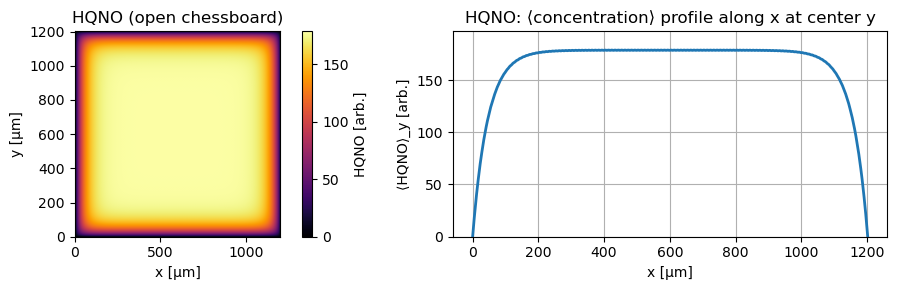

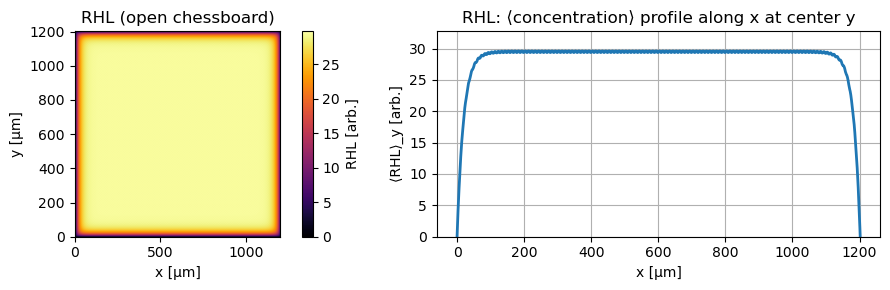

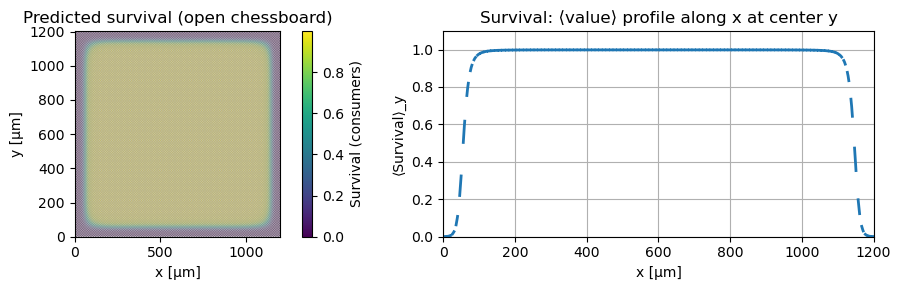

Running new simulation and saving to data/open_colony_simulation_tile10.pkl


In [ ]:

# Load survival parameters from JSON
SURVIVAL_JSON = Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters.json'
# Load parameters of fitted survival models
with open(SURVIVAL_JSON, "r", encoding="utf-8") as f:
    logit_model = json.load(f)
# use parameters of the 'hqno_max_60' model as this fits the empirical concentration ranges best
model_params = logit_model['hqno_max_80']['parameters']


# Load model parameters
parameter_CSV = Path.cwd().parent / '4_1D_model' / 'data' / '3_full_model_parameters.csv'
df = pd.read_csv(parameter_CSV)
cols = ['uptake rate', 'production rate', 'Deff']

df_h = df[df['molecule'] == 'HQNO'][cols].quantile([0.25, 0.5, 0.75])
df_r = df[df['molecule'] == 'RHL'][cols].quantile([0.25, 0.5, 0.75])

patch_size =[5, 10, 25, 50, 100, 200, 400, 600]

for ps in patch_size:
    file_name = f'data/open_colony_simulation_tile{ps}.pkl'

    if Path(file_name).is_file():
        # Load existing simulation data from file if available
        with open(file_name, 'rb') as f:
            data = pickle.load(f)
        HQNO = data['HQNO']
        RHL = data['RHL']
        SURV = data['SURV']
        cfg = data['cfg']
        info = data['info']
        print("Loaded existing simulation data from", file_name)
    else:
        print("Running new simulation and saving to", file_name)
        # ------------------ Run simulation ------------------
        cfg = SimConfig(
            mode="open_chessboard",
            W_um=1200, tile_um=ps,
            dx_um=1.0, dy_um=1.0,
            D_HQNO_um2_per_s=df_h.at[0.5, 'Deff'],
            S_HQNO_prod_per_s=df_h.at[0.5, 'production rate'],
            up_HQNO_cons_per_s=df_h.at[0.5, 'uptake rate'],
            D_RHL_um2_per_s=df_r.at[0.5, 'Deff'],
            S_RHL_prod_per_s=df_r.at[0.5, 'production rate'],
            up_RHL_cons_per_s=df_r.at[0.5, 'uptake rate'],
            compute_survival=True,
            make_plots=False, verbose=False,
            m_rhl = model_params["m_rhl"],
            m_hqno = model_params["m_hqno"],
            b = model_params["b"]
        )

        (HQNO, RHL, SURV), info = run_simulation(cfg)

        # Save simulation data to file
        with open(file_name, 'wb') as f:
            pickle.dump({
                'HQNO': HQNO,
                'RHL': RHL,
                'SURV': SURV,
                'cfg': cfg,
                'info': info
            }, f)

    # ------------------ Plot results ------------------
    Lx = HQNO.shape[0] * cfg.dx_um
    Ly = HQNO.shape[1] * cfg.dy_um
    extent = [0, Lx, 0, Ly]
    plot_field_maps(HQNO, RHL, SURV, extent, mode_title="(open chessboard)")

In [ ]:

stats = []

for ps in patch_size:
    file_name = f'data/open_colony_simulation_tile{ps}.pkl'

    with open(file_name, "rb") as f:
        output = pickle.load(f)
        stats.append({
            "spacing_um": ps,
            "mean_survival": np.nanmean(output['SURV'][:])
        })
df_stats = pd.DataFrame(stats)

sns.barplot(data=df_stats, x='spacing_um', y='mean_survival')
plt.xlabel("Tile Spacing (μm)")
plt.ylabel("Mean Predicted Survival")
plt.title("Mean Predicted Survival vs Tile Spacing")
plt.show()
